In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML


In [3]:
# Load the data
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
def load_training_data(interpolated_dir, test = [2023, 2024]):
    training_data = {}
    for folder in os.listdir(interpolated_dir):
        folder_path = os.path.join(interpolated_dir, folder)
        print(f"Loading data for {folder}")
        if os.path.isdir(folder_path):
            if not(int(folder) in test):
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        for _, row in df.iloc[1:].iterrows():
                            row["relative_strength"] = df.iloc[0]["homeWinProbability"]
                            row["away_team_id"] = df.iloc[0]["away_team_id"]
                            row["home_team_id"] = df.iloc[0]["home_team_id"]
                            row["home_win"] = df.iloc[0]["home_win"]
                            if row["timestep"] not in training_data:
                                training_data[row["timestep"]] = [row] 
                            else:
                                training_data[row["timestep"]] += [row]
            else: 
                print("skipping ", folder)
    return training_data

training_data = load_training_data(interpolated_dir)

Loading data for 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for 2015
Loading data for .DS_Store
Loading data for 2017
Loading data for 2019
Loading data for 2021
Loading data for 2020
Loading data for 2018
Loading data for 2016


In [4]:
print(len(training_data))

201


In [5]:
# Get information about the data
for timestep in training_data:
    print(f"timestep: {timestep}, number of instances: {len(training_data[timestep])}")

timestep: 0.0, number of instances: 2801
timestep: 0.005, number of instances: 2092
timestep: 0.01, number of instances: 1894
timestep: 0.015, number of instances: 2074
timestep: 0.02, number of instances: 1959
timestep: 0.025, number of instances: 2109
timestep: 0.03, number of instances: 2086
timestep: 0.035, number of instances: 2079
timestep: 0.04, number of instances: 2115
timestep: 0.045, number of instances: 2103
timestep: 0.05, number of instances: 2108
timestep: 0.055, number of instances: 2162
timestep: 0.06, number of instances: 2133
timestep: 0.065, number of instances: 2172
timestep: 0.07, number of instances: 2162
timestep: 0.075, number of instances: 2182
timestep: 0.08, number of instances: 2197
timestep: 0.085, number of instances: 2100
timestep: 0.09, number of instances: 2231
timestep: 0.095, number of instances: 2187
timestep: 0.1, number of instances: 2252
timestep: 0.105, number of instances: 2190
timestep: 0.11, number of instances: 2198
timestep: 0.115, number o

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Define which features to scale vs. passthrough
numeric_features = [
    "homeScore", "awayScore", "start.down", "start.distance", "start.yardLine",
    "end.down", "end.distance", "end.yardLine",
]
other_features = ["relative_strength", "scoringPlay", "home_has_possession", "home_timeouts_left", "away_timeouts_left"] # for timestep in training_data.keys():

features = ["home_win"] + numeric_features + other_features

# Scale the data pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("passthrough", "passthrough", other_features)
])

preprocessor_no_scaling = ColumnTransformer(transformers=[
    ("passthrough", "passthrough", numeric_features + other_features)
])

# TO DO:
# - Rounding for end games
# - Only keep home_has_possession + timeouts_left + everything I had before - DONE
# - Kernel based methods
#   - At least 10 data points to do an estimation
#   - Score difference - make it categorical

In [7]:
for timestep in training_data.keys():
    rows = training_data[timestep]
    
    # Replace NaN values with 0
    for row in rows:
        for feature in features:
            if np.isnan(row[feature]):
                row[feature] = 0

In [8]:
# Feature Selection
def feature_selection(data, features, replace_nan_val = 0):
    # Given the features of the data, return data such that each row is an array of the values of the features
    # The data is a dictionary where the key is the timestep and the value is a list of rows
    feature_data = {}
    for timestep in data:
        feature_data[timestep] = []
        for row in data[timestep]:
            new_row = [float(row[feature]) for feature in features]
            # First check if the row has any NaN values
            new_row = [val if not np.isnan(val) else replace_nan_val for val in new_row] 
            feature_data[timestep].append(new_row)
    return feature_data

features_data = feature_selection(training_data, features)

In [9]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


def create_model():
    return Pipeline(steps=[
        ("preprocessor", preprocessor_no_scaling),
        ("model", LogisticRegression(max_iter=2000))
    ])
# create an array of logistic regression models
models = {}
def setup_models(features_data):
    for timestep in features_data:
        data = np.array(features_data[timestep])
        X_df = pd.DataFrame(data[:, 1:], columns=features[1:]) # Not including home_win (label)
        y = data[:, 0]
        model = create_model()
        print("Training for timestep", timestep)
        model.fit(X_df, y)
        
        # Calculate training loss
        y_pred = model.predict_proba(X_df)[:, 1]  # Get probability predictions
        loss = -np.mean(y * np.log(y_pred + 1e-15) + (1-y) * np.log(1-y_pred + 1e-15))  # Binary cross entropy
        accuracy = model.score(X_df, y)
        print(f"Timestep {timestep:.2%}: Training Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        models[timestep] = model


setup_models(features_data)



Training for timestep 0.0
Timestep 0.00%: Training Loss = 0.6265, Accuracy = 0.6444
Training for timestep 0.005
Timestep 0.50%: Training Loss = 0.6275, Accuracy = 0.6420
Training for timestep 0.01
Timestep 1.00%: Training Loss = 0.6279, Accuracy = 0.6420
Training for timestep 0.015
Timestep 1.50%: Training Loss = 0.6263, Accuracy = 0.6514
Training for timestep 0.02
Timestep 2.00%: Training Loss = 0.6264, Accuracy = 0.6478
Training for timestep 0.025
Timestep 2.50%: Training Loss = 0.6281, Accuracy = 0.6382
Training for timestep 0.03
Timestep 3.00%: Training Loss = 0.6220, Accuracy = 0.6448
Training for timestep 0.035
Timestep 3.50%: Training Loss = 0.6250, Accuracy = 0.6498
Training for timestep 0.04
Timestep 4.00%: Training Loss = 0.6187, Accuracy = 0.6572
Training for timestep 0.045
Timestep 4.50%: Training Loss = 0.6277, Accuracy = 0.6510
Training for timestep 0.05
Timestep 5.00%: Training Loss = 0.6184, Accuracy = 0.6575
Training for timestep 0.055
Timestep 5.50%: Training Loss = 0

In [10]:
def load_test_data(interpolated_dir, test = [2023, 2024]):
    test_folders = {}
    for folder in os.listdir(interpolated_dir):
        folder_path = os.path.join(interpolated_dir, folder)
        print(f"Loading data for {folder}")
        if os.path.isdir(folder_path):
            if int(folder) in test:
                test_data = {}
                for file in os.listdir(folder_path):
                    if file.endswith(".csv"):
                        seen_timesteps = set()
                        file_path = os.path.join(folder_path, file)
                        df = pd.read_csv(file_path)
                        for _, row in df.iloc[1:].iterrows():
                            row["relative_strength"] = df.iloc[0]["homeWinProbability"]
                            row["away_team_id"] = df.iloc[0]["away_team_id"]
                            row["home_team_id"] = df.iloc[0]["home_team_id"]
                            row["home_win"] = df.iloc[0]["home_win"]
                            if file not in test_data and row["timestep"] not in seen_timesteps:
                                seen_timesteps.add(row["timestep"])
                                test_data[file] = [row] 
                            elif row["timestep"] not in seen_timesteps:
                                seen_timesteps.add(row["timestep"]) 
                                test_data[file] += [row]
                test_folders[folder] = test_data
    return test_folders
test_folders = load_test_data(interpolated_dir)
for timestep in test_folders:
    print(f"timestep: {timestep}, number of instances: {len(test_folders[timestep])}")
print(test_folders.keys())

Loading data for 2022
Loading data for 2024
Loading data for 2023
Loading data for 2015
Loading data for .DS_Store
Loading data for 2017
Loading data for 2019
Loading data for 2021
Loading data for 2020
Loading data for 2018
Loading data for 2016
timestep: 2024, number of instances: 272
timestep: 2023, number of instances: 272
dict_keys(['2024', '2023'])


In [11]:
def test_feature_selection(data, features, replace_nan_val = 0):
    # Given the features of the data, return data such that each row is an array of the values of the features
    # The data is a dictionary where the key is the timestep and the value is a list of rows
    feature_data = {}
    for file in data:
        feature_data[file] = []
        for row in data[file]:
            new_row = [[float(row[feature]) for feature in features]]
            # First check if the row has any NaN values
            new_row = [[val if not np.isnan(val) else replace_nan_val for val in new_row[0]]] 
            feature_data[file] += new_row
    return feature_data
features_test_data = {key: test_feature_selection(test_data, features) for key, test_data in zip(test_folders.keys(), test_folders.values())}

In [12]:
X_tests = [features_test_data[year] for year in features_test_data]
merged = {}
for d in X_tests:
    merged.update(d)
X_tests = merged
new_X_tests = {}
print(len(X_tests))
for file in X_tests:
   timestep = 0
   for i in range(len(X_tests[file])):
        if timestep not in new_X_tests:
           new_X_tests[timestep] = [X_tests[file][i]]
        else:
            new_X_tests[timestep] += [X_tests[file][i]]
        timestep += 0.005
X_tests = new_X_tests
# len(X_tests[0.1])
X_tests.keys()

544


dict_keys([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030000000000000002, 0.035, 0.04, 0.045, 0.049999999999999996, 0.05499999999999999, 0.05999999999999999, 0.06499999999999999, 0.06999999999999999, 0.075, 0.08, 0.085, 0.09000000000000001, 0.09500000000000001, 0.10000000000000002, 0.10500000000000002, 0.11000000000000003, 0.11500000000000003, 0.12000000000000004, 0.12500000000000003, 0.13000000000000003, 0.13500000000000004, 0.14000000000000004, 0.14500000000000005, 0.15000000000000005, 0.15500000000000005, 0.16000000000000006, 0.16500000000000006, 0.17000000000000007, 0.17500000000000007, 0.18000000000000008, 0.18500000000000008, 0.19000000000000009, 0.1950000000000001, 0.2000000000000001, 0.2050000000000001, 0.2100000000000001, 0.2150000000000001, 0.2200000000000001, 0.22500000000000012, 0.23000000000000012, 0.23500000000000013, 0.24000000000000013, 0.24500000000000013, 0.2500000000000001, 0.2550000000000001, 0.2600000000000001, 0.2650000000000001, 0.27000000000000013, 0.2750000000000001

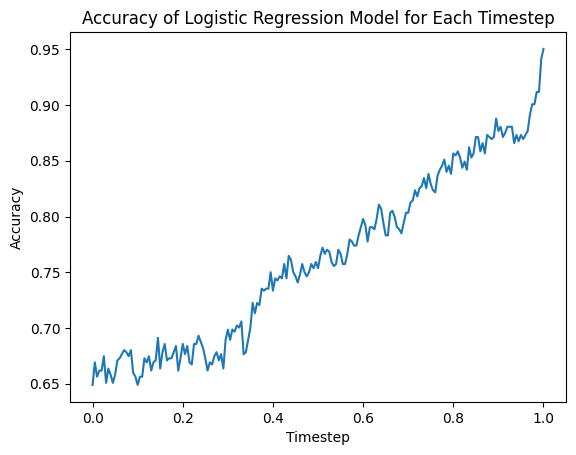

In [13]:
# Test accuracy of model for each timestep on test data and plot
accuracies = []
timesteps = []

for timestep, i in zip(models, X_tests.keys()):
    model = models[timestep]
    
    # Convert test data to array
    X_test_array = np.array(X_tests[i])
    
    # Split into labels and features
    y_test = X_test_array[:, 0]
    X_test = X_test_array[:, 1:]
    
    # Create a DataFrame with correct column names
    X_test_df = pd.DataFrame(X_test, columns=features[1:])  # Exclude the label column
    
    # Evaluate model using the pipeline (preprocessing + logistic regression)
    accuracy = model.score(X_test_df, y_test)
    
    accuracies.append(accuracy)
    timesteps.append(timestep)

# Plot accuracy per timestep
plt.plot(timesteps, accuracies)
plt.xlabel("Timestep")
plt.ylabel("Accuracy")
plt.title("Accuracy of Logistic Regression Model for Each Timestep")
plt.show()

In [101]:
# Save the model
import pickle
filename = 'logistic_regression_model.pickle'
pickle.dump(models, open(filename, 'wb'))

In [103]:
# Write the predictions to csv file
# CHANGE CSV COLUMN NAME
for folder in features_test_data:
    print(folder)
    test_data = features_test_data[folder]
    
    for file in test_data:
        df_path = os.path.join(interpolated_dir, folder, file)
        df = pd.read_csv(df_path)
        print(file)

        rows = df.iloc[1:].iterrows()
        try:
            index, row = next(rows)
        except StopIteration:
            continue

        for i, timestep in zip(range(len(models)), models):
            model = models[timestep]
            
            # Get test features for this timestep (skip label)
            feature_vector = np.array(test_data[file][i])[1:]
            
            # Convert to DataFrame with proper column names
            X_test = pd.DataFrame([feature_vector], columns=features[1:])

            # Predict probability using the pipeline
            pred = model.predict_proba(X_test)
            
            # Add prediction to DataFrame for matching timesteps
            try:
                while round(row["timestep"], 3) == round(timestep, 3):
                    df.at[index, "phat_b_LR_2"] = pred[0][1]
                    index, row = next(rows)
            except StopIteration:
                break

        # Save updated file
        df.to_csv(df_path, index=False)
        print(f"Finished writing to {file}")

2024
game_401671629.csv
Finished writing to game_401671629.csv
game_401671601.csv
Finished writing to game_401671601.csv
game_401671826.csv
Finished writing to game_401671826.csv
game_401671832.csv
Finished writing to game_401671832.csv
game_401671749.csv
Finished writing to game_401671749.csv
game_401671775.csv
Finished writing to game_401671775.csv
game_401671761.csv
Finished writing to game_401671761.csv
game_401671760.csv
Finished writing to game_401671760.csv
game_401671774.csv
Finished writing to game_401671774.csv
game_401671748.csv
Finished writing to game_401671748.csv
game_401671833.csv
Finished writing to game_401671833.csv
game_401671827.csv
Finished writing to game_401671827.csv
game_401671600.csv
Finished writing to game_401671600.csv
game_401671628.csv
Finished writing to game_401671628.csv
game_401671616.csv
Finished writing to game_401671616.csv
game_401671831.csv
Finished writing to game_401671831.csv
game_401671825.csv
Finished writing to game_401671825.csv
game_4016

# For Debugging Purposes

In [120]:
for folder in os.listdir(interpolated_dir):
    if not os.path.isdir(os.path.join(interpolated_dir, folder)):
        continue
    print(folder)
    for file in os.listdir(os.path.join(interpolated_dir, folder)):
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(interpolated_dir, folder, file))
            # check if data.iloc[1]["homeScore"] is NaN
            if pd.isna(data.iloc[1]["homeScore"]) or pd.isna(data.iloc[1]["awayScore"]):
                print(file)

2022
2023
2019
2021
2020
2018
